Euclidean metric and the CI made out of the box (took one step in four directions and integrated over that box once it hit the true value). 

This notebook is all about coming up with ways to asses how good a job PyVBMC does. 

To start, we'll state the differential equation of interest, get integration working for that equation, and run a PyVBMC optimize routine on it.


The differential equation:

$$\ddot{x} = -x -ax^b$$

generalized to deal with all values of b:

$$\ddot{x} = -x - sign(x)a|x|^b$$

$0<a\leq0.5$

 $1\leq b \leq 5$

In [18]:
import pandas as pd  # Data handling
import matplotlib.pyplot as plt # visualization
from scipy.integrate import odeint # numerical integration
import numpy as np
from pyvbmc import VBMC # VMBC object
import scipy.stats as scs # scipy stats to get distributions from
from pyvbmc.priors import UniformBox, Trapezoidal, SplineTrapezoidal, SmoothBox # nice priors from PyVBMC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# import scipy.stats as scs
import scipy.integrate as integrate
# import numpy as np
# import matplotlib.pyplot as plt

In [8]:
def diffyqs(X, t, a,b):
    x, vx = X[0], X[1]
    dx = vx
    dv = -x - np.sign(x) * a * np.abs(x)**b
    return [dx, dv]

initial_condition = [0.0, 3.5]
t = np.arange(0,10,0.05)

a = 0.2
b = 2.0
sol = odeint(diffyqs, initial_condition, t, args=(a,b))
u = 0.1
v = 2.5
sol2 = odeint(diffyqs, initial_condition, t, args=(u,v))

x_true = sol[:,1]

a_min = 0.0
a_max = 0.5
b_min = 1.0
b_max = 5.0

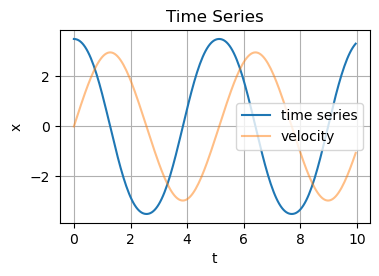

In [12]:
def plot_ts(t,ts,v, mode = 0):
    plt.figure(figsize=(4,2.5))
    if mode == 0:
        plt.plot(t,ts)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.grid()
        plt.show()
    else:
        plt.plot(t,ts, label = 'time series')
        plt.plot(t,v, label = 'velocity', alpha = 0.5)
        plt.title('Time Series')
        plt.xlabel('t')
        plt.ylabel('x')
        plt.legend()
        plt.grid()
        plt.show()

plot_ts(t,sol[:, 1],sol[:, 0],1)
# plot_ts(t,sol2[:, 1],sol2[:, 0],1)

In [10]:
def log_likelihood(theta):
    a,b = theta

    sol = odeint(diffyqs, initial_condition, t, args=(a,b)) # get solution of ODE with current choice of params
    
    return -np.sum((sol[:,1] - x_true)**2) # normal distribution sorta

In [13]:
D = 2  # 2-D since there are 2 params we're estimating

LB = np.full((1, D), a_min)  # Lower bounds
LB[0][1] = b_min
UB = np.full((1, D), a_max)  # Upper bounds
UB[0][1] = b_max

PLB = np.copy(LB) + 0.05
PUB = np.copy(UB) - 0.05

x0 = np.full((1, D), 0.11) # starting point for inference   # 1.5 * np.ones((1, D))
x0[0][1] = 3.5

print(LB,PLB,PUB,UB,'x0:',x0)

[[0. 1.]] [[0.05 1.05]] [[0.45 4.95]] [[0.5 5. ]] x0: [[0.11 3.5 ]]


In [20]:
prior1 = SplineTrapezoidal(LB, PLB, PUB, UB)

options1 = {
    "display": "off"
}

#vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior, options = options) # initialize VMBC object

In [17]:
def euclidean_metric(vp,truth_array, n_samples = int(1e6)): 
    """
    Returns a measure of how close the actual parameters are to the estimated parameters,
    computed by finding the euclidean distance between the mean of a large sample of the 
    varaitional posterior and the true values of the parameters.

    vp: varational posterior from PyVBMC
    truth_array: numpy array of the true values of the parameters (must be in the same order as the vp returns!)
    """
    Xs, _ = vp.sample(n_samples) # sample vp
    # scaler = StandardScaler() # create scaler (don't bother centering)
    # scaler = MinMaxScaler(feature_range=(0,1))
    scaler = MinMaxScaler()
    scaler.fit(Xs)                     # fit scaler to samples
    scaled_data = scaler.transform(Xs) # scale samples
    mean = np.array([scaled_data[:,0].mean(),scaled_data[:,1].mean()]) # compute mean of samples
    truth_scaled = scaler.transform(truth_array) # scale true data
    return np.linalg.norm(mean-truth_scaled) # return distance between mean and truth

# call the function on our current example
#euclidean_metric(vp,np.array([[a,b]]))

In [21]:
vbmc = VBMC(log_likelihood, x0, LB, UB, PLB, PUB, prior = prior1, options = options1) # initialize VMBC object

vp, results = vbmc.optimize() # do optimization (might take a while)

Inference terminated: variational solution stable for options.tol_stable_count fcn evaluations.
Estimated ELBO: -4.915 +/-0.001.


In [24]:
vp.moments()
# vp.plot()

array([[0.24551166, 1.86459083]])

In [31]:
pdf_simple = lambda x,y: vp.pdf(np.array([[y,x]]))
def CI_2D(vp,pdf,true_value,step = 0.05,n_samples = int(5e5)):
    # do sampling, take mode of samples
    Xs, _ = vp.sample(n_samples) # sample vp
    pdf_mode = scs.mode(Xs,keepdims = True)[0]
    print("mode:",pdf_mode)
    a0,b0 = pdf_mode[0][0] - step, pdf_mode[0][0] + step
    a1,b1 = pdf_mode[0][1] - step, pdf_mode[0][1] + step
    print("a0, b0:", a0, b0, "a1, b1:", a1, b1)
    I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
    print(I)
    print(true_value)
    def check_if_in_CI(true_value,a0,b0,a1,b1):
        # if a0 <= true_value[0] and true_value[0] <= b0 \
        #     and a1 <= true_value[1] and true_value[1] <= b1:

        if a0 <= true_value[0] <= b0 and a1 <= true_value[1] <= b1:
            print("hit")
            return False
        else:
            return True
    iter = 0
    while check_if_in_CI(true_value,a0,b0,a1,b1):
        I = integrate.dblquad(pdf, a0, b0, a1, b1)[0]
        a0 -= step
        b0 += step
        a1 -= step
        b1 += step
        #print("iter",iter )
        iter += 1
        print(I)
    return I
print("CI:",CI_2D(vp,pdf_simple,[0.2,2.0],0.1))


mode: [[0.04683791 1.01351155]]
a0, b0: -0.05316209285902826 0.14683790714097175 a1, b1: 0.9135115462440123 1.1135115462440124
0.0
[0.2, 2.0]
0.0
3.7414308942212677e-146
5.2201674078736016e-09
0.15625521288500782
0.24510127449070623
0.32507471496308366
0.40879270695402503
0.49223322192164914
0.5710245167723486
hit
CI: 0.5710245167723486
